# Electricity Price Forecasting

## Overview

Data exploration, visualization and implementation of a forecasting model for elecricity price given the hisorical price and the load data and wind generation data.

Data used is from the NordPool market, which is freely available from their website NordPoolgroup.com

## Data Exploration

The data will be downloaded, saved locally and then scaled appropriately, before being uploaded to S3

In [1]:
import sys
sys.executable

'/home/ec2-user/anaconda3/envs/python3/bin/python'

In [1]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer
from epftoolbox.data import read_data
from epftoolbox.data import DataScaler
import matplotlib.pyplot as plt
import io
import os
import time
import json


# Session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/EPF_linear_learner'

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

In [2]:
path = 'NordPool_data/'
dataset = 'NP'
# Want our test dataset to be the last 2 years of the total dataset, which is 6 years
years_test = 2 
df_train, df_test = read_data(path=path, dataset=dataset, years_test=years_test)
df_train.head()

,Price,Exogenous 1,Exogenous 2
Date,,,
2013-01-01 00:00:00,31.05,42497.0,2798.0
2013-01-01 01:00:00,30.47,41463.0,2417.0
2013-01-01 02:00:00,28.92,40812.0,2036.0
2013-01-01 03:00:00,27.88,40246.0,1706.0
2013-01-01 04:00:00,26.96,40088.0,1427.0


Text(0.5, 0.98, 'Price Data, Load Data (Exogenous 1) and Wind Generation (Exogenous 2)')

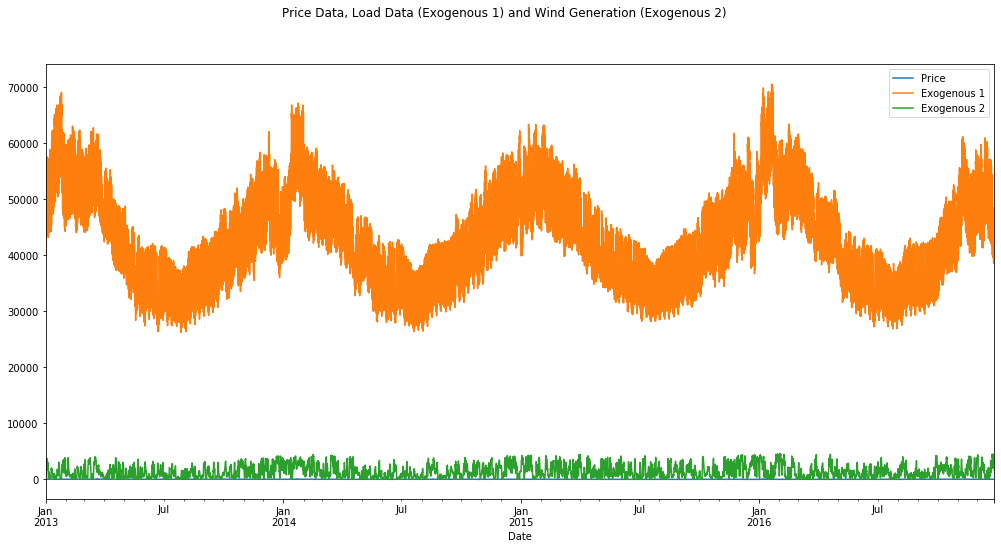

In [3]:
original_data = pd.read_csv('NordPool_data/NP.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df_train.plot(figsize=(17, 8))
plt.suptitle('Price Data, Load Data (Exogenous 1) and Wind Generation (Exogenous 2)')

As seen from the above plot, the values for the day-ahead load forecast and the day-ahead wind generation forecast are so much greater than the day-ahead price, that the price data is barely visible on the plot.

This indicates the data needs to be scaled prior to training or testing.

Text(0.5, 0.98, 'Day-ahead Price Data, Jan 2013 - Dec 2016')

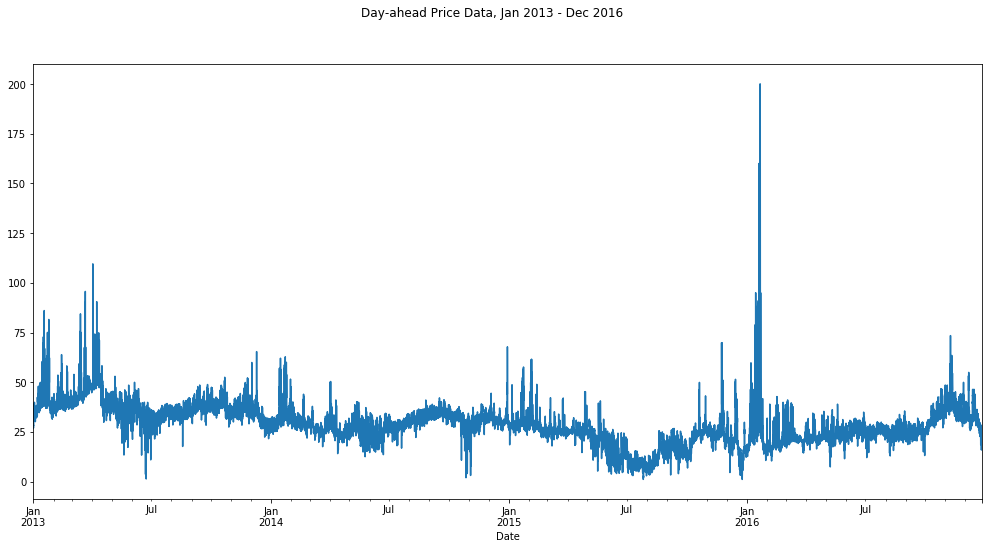

In [14]:
df_train.Price.plot(figsize=(17, 8))
plt.suptitle('Day-ahead Price Data, Jan 2013 - Dec 2016')

Text(0.5, 0.98, 'Day-ahead Load Forecast, Jan 2013 - Dec 2016')

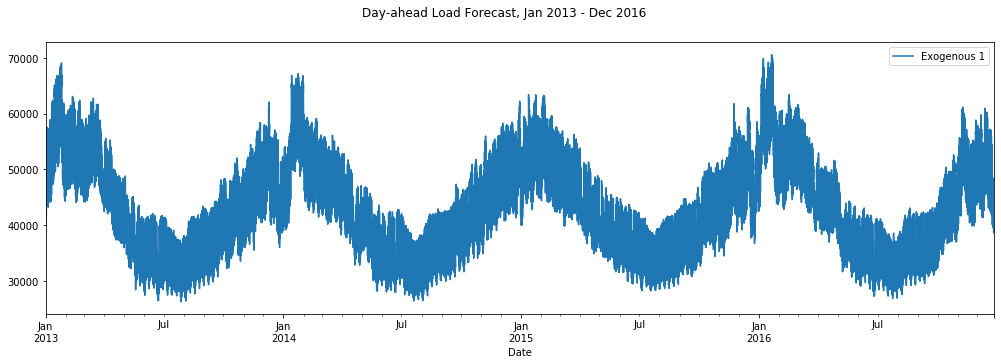

In [21]:
df_train.plot(y='Exogenous 1', figsize=(17, 5))
plt.suptitle('Day-ahead Load Forecast, Jan 2013 - Dec 2016')

Text(0.5, 0.98, 'Day-ahead Wind Forecast, Jan 2013 - Dec 2016')

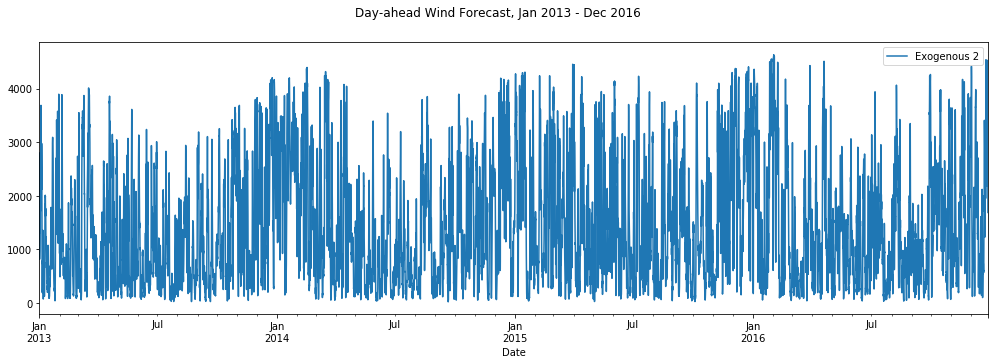

In [22]:
df_train.plot(y='Exogenous 2', figsize=(17, 5))
plt.suptitle('Day-ahead Wind Forecast, Jan 2013 - Dec 2016')

### Data Scaling
Create a scaler for the input data

No handles with labels found to put in legend.


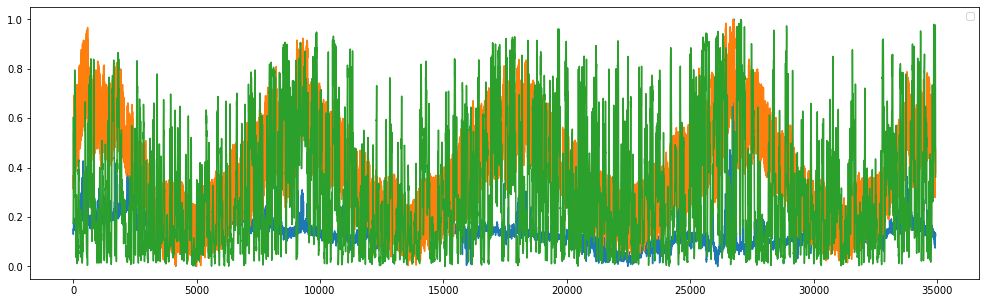

In [4]:
Xtrain = df_train.values
Xtest = df_test.values
scaler_X = DataScaler('Norm')
Xtrain_scaled = scaler_X.fit_transform(Xtrain)
Xtest_scaled = scaler_X.transform(Xtest)
Xtrain_inverse = scaler_X.inverse_transform(Xtrain_scaled)
Xtest_inverse = scaler_X.inverse_transform(Xtest_scaled)

plt.figure(figsize=(17,5))
plt.plot(Xtrain_scaled)
plt.legend()

Create a scaler for the output

[[31.05]
 [30.47]
 [28.92]]


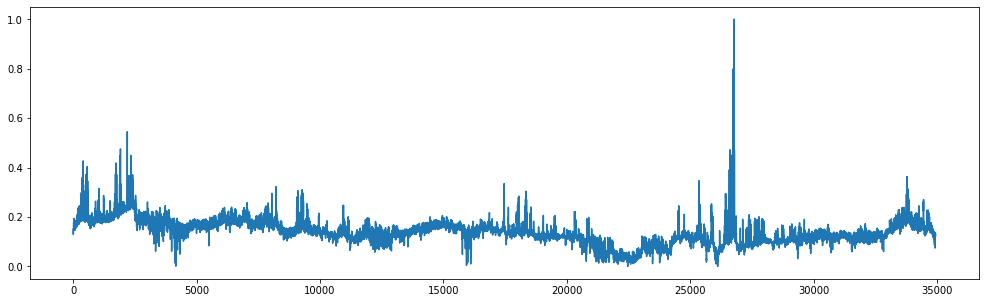

In [5]:
Ytrain = df_train.Price.values
YtrainR = Ytrain.reshape(-1,1)
print(YtrainR[0:3])

# Use the same type of normalisation as the test
scaler_Y = DataScaler('Norm')
Ytrain_scaled = scaler_Y.fit_transform(YtrainR)
plt.figure(figsize=(17,5))
plt.plot(Ytrain_scaled)

## Training

Now that all of our data has been scaled appropriately, we can use it to train or model.

Text(0.5, 0.98, 'Training Label Data, scaled')

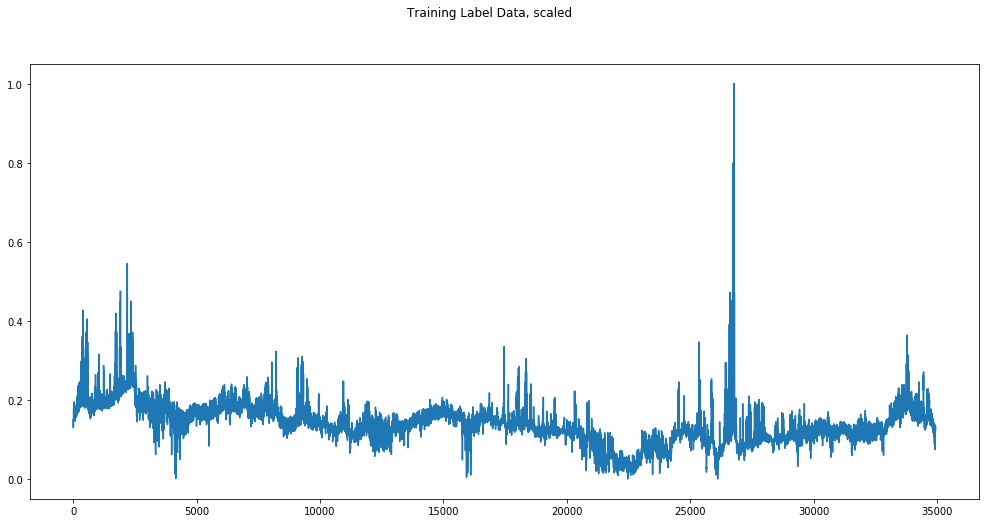

In [6]:
# The label is the price of the electricty and the wind and load data are the features
train_y = Ytrain_scaled

# Remove the price for the training set
train_X = np.delete(Xtrain_scaled, obj=0, axis=1)

plt.figure(figsize=(17,8))
plt.plot(train_y)
plt.suptitle('Training Label Data, scaled')

Text(0.5, 0.98, 'Training Input Data, scaled')

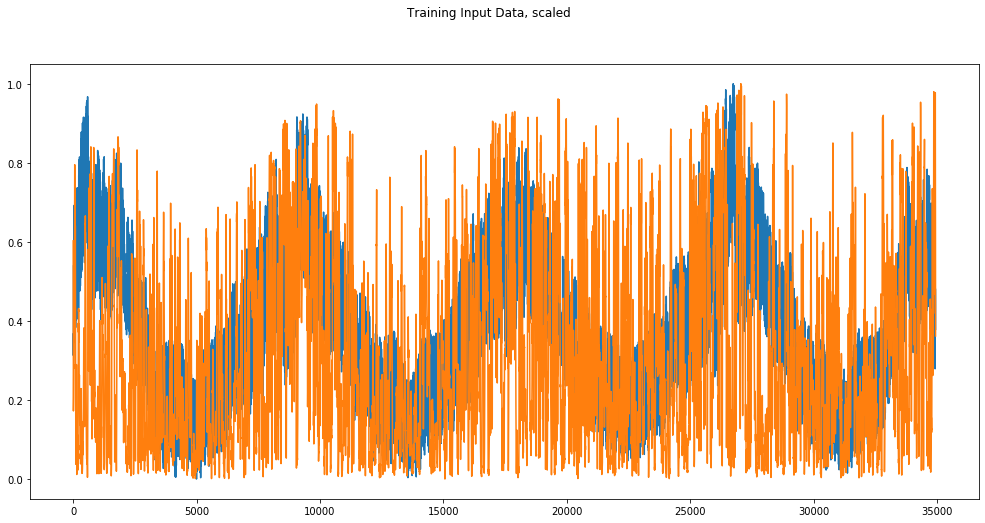

In [7]:
plt.figure(figsize=(17,8))
plt.plot(train_X)
plt.suptitle('Training Input Data, scaled')

Text(0.5, 0.98, 'Test Input Data, scaled')

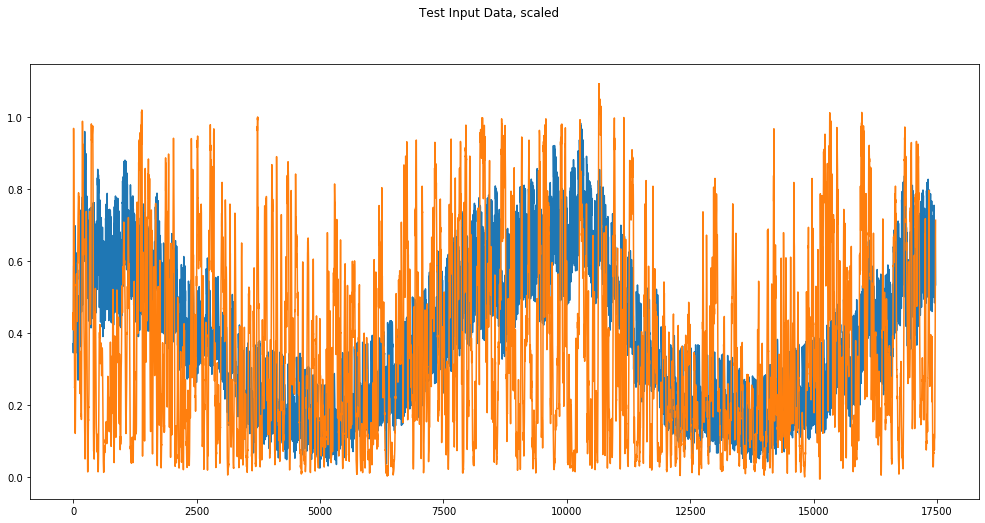

In [18]:
# Repeat for test set
test_X = np.delete(Xtest_scaled,obj=0, axis=1) # Remove the price for the test input set

plt.figure(figsize=(17,8))
plt.plot(test_X)
plt.suptitle('Test Input Data, scaled')

Reshape the data and convert into pd.Series object

In [8]:
train_y = train_y.reshape(-1)

print(train_y.shape)
# Turn lables back into Series object
train_y = pd.Series(train_y)
train_y.head()

(34944,)


0    0.150430
1    0.147513
2    0.139717
3    0.134487
4    0.129860
dtype: float64

SageMaker algorithms require the data to be in recordIO-wrapped protobuf format

In [9]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_y).astype('float32'))
buf.seek(0)

0

Upload the training set to S3

In [10]:
key = 'linear_train.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-eu-west-1-871247501960/sagemaker/EPF_linear_learner/train/linear_train.data


In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [13]:
estimator = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=sagemaker_session)

estimator.set_hyperparameters(feature_dim=2,
                           mini_batch_size=100,
                           predictor_type='regressor',
                           epochs=20,
                           loss='absolute_loss')

estimator.fit({'train': s3_train_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-11-22 21:05:51 Starting - Starting the training job...
2020-11-22 21:05:53 Starting - Launching requested ML instances......
2020-11-22 21:06:58 Starting - Preparing the instances for training.........
2020-11-22 21:08:40 Downloading - Downloading input data
2020-11-22 21:08:40 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/22/2020 21:08:58 INFO 140072231204672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'ini

[2020-11-22 21:09:21.127] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 6659, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.782285819313246, "sum": 0.782285819313246, "min": 0.782285819313246}}, "EndTime": 1606079361.127836, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1606079361.127739}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6710211170710261, "sum": 0.6710211170710261, "min": 0.6710211170710261}}, "EndTime": 1606079361.127945, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1606079361.127925}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.7821648005018261, "sum": 0.7821648005018261, "min": 0.7821648005018261}}, "EndTime": 1606079361

[2020-11-22 21:09:27.838] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 6701, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.8687609687575638, "sum": 0.8687609687575638, "min": 0.8687609687575638}}, "EndTime": 1606079367.839135, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1606079367.839039}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6727274071657897, "sum": 0.6727274071657897, "min": 0.6727274071657897}}, "EndTime": 1606079367.839215, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1606079367.839196}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.8687389312022736, "sum": 0.8687389312022736, "min": 0.8687389312022736}}, "EndTime": 1606079

[2020-11-22 21:09:41.409] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 13, "duration": 6741, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9500861756507851, "sum": 0.9500861756507851, "min": 0.9500861756507851}}, "EndTime": 1606079381.409302, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1606079381.409203}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6779558833485688, "sum": 0.6779558833485688, "min": 0.6779558833485688}}, "EndTime": 1606079381.409406, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1606079381.409383}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9501449780067946, "sum": 0.9501449780067946, "min": 0.9501449780067946}}, "EndTime": 160607

[2020-11-22 21:09:48.121] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 6702, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9587334745183032, "sum": 0.9587334745183032, "min": 0.9587334745183032}}, "EndTime": 1606079388.121558, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1606079388.121461}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6808717080037027, "sum": 0.6808717080037027, "min": 0.6808717080037027}}, "EndTime": 1606079388.121639, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1606079388.12162}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9587380469357728, "sum": 0.9587380469357728, "min": 0.9587380469357728}}, "EndTime": 1606079

[2020-11-22 21:10:01.790] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 19, "duration": 6875, "num_examples": 350, "num_bytes": 1817088}
#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9534735081735518, "sum": 0.9534735081735518, "min": 0.9534735081735518}}, "EndTime": 1606079401.790187, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1606079401.790089}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.6871209400089558, "sum": 0.6871209400089558, "min": 0.6871209400089558}}, "EndTime": 1606079401.790287, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1606079401.790267}

#metrics {"Metrics": {"train_absolute_loss_objective": {"count": 1, "max": 0.9534738163825093, "sum": 0.9534738163825093, "min": 0.9534738163825093}}, "EndTime": 160607


2020-11-22 21:10:13 Uploading - Uploading generated training model
2020-11-22 21:10:13 Completed - Training job completed
Training seconds: 104
Billable seconds: 104


## Deployment

Deploy the trained model to an endpoint, in order to pass in test data for prediction

In [15]:
predictor = estimator.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

-----------------!

In [16]:
predictor.serializer = csv_serializer
predictor.deserializer = json_deserializer

In [19]:
result = predictor.predict(test_X)

one_step = np.array([r['score'] for r in result['predictions']])
#print(one_step.shape)

scaled_one_step = scaler_Y.inverse_transform(one_step.reshape(1,-1))


The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [32]:
one_step_R = scaled_one_step.reshape(-1,1)
one_step_R2 = scaled_one_step.reshape(-1)
print(one_step_R2.shape)

print(scaled_one_step.shape)
print(one_step_R.shape)
test_y = df_test.Price.values
print(test_y.shape)
print(test_y[0:3])

print(type(test_y))
print(type(one_step_R))

(17472,)
(1, 17472)
(17472, 1)
(17472,)
[24.08 22.52 20.13]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


One-step-ahead MdAPE =  0.22981055277368803
One-step-ahead RMSE =  10.781923216020868


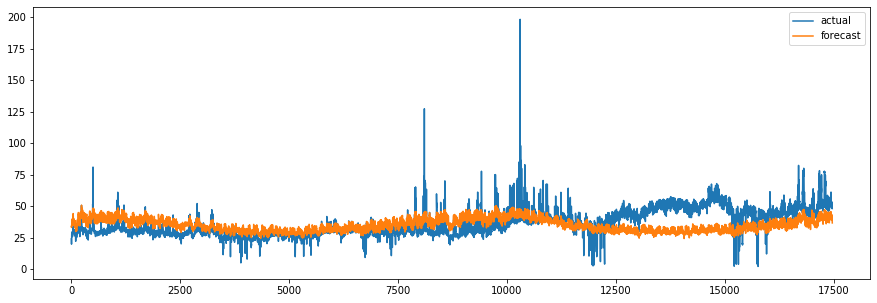

In [36]:
print('One-step-ahead MdAPE = ', np.median(np.abs(test_y - one_step_R2) / test_y))
#actual, pred = np.array(actual), np.array(pred)
#    return np.mean(np.abs((actual - pred) / actual)) * 100
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(test_y, one_step_R2))

print('One-step-ahead RMSE = ', rms)

plt.figure(figsize=(15,5))
plt.plot(np.array(test_y), label='actual')
plt.plot(one_step_R, label='forecast')
plt.legend()
plt.show()

## Delete Endpoint

In [79]:
sagemaker_session.delete_endpoint(endpoint_name)

NameError: name 'endpoint_name' is not defined